In [1]:
import warnings
import shap
import os
import pickle
import math
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import date
from sklearn.model_selection import train_test_split
from hyperopt import fmin,hp,Trials,space_eval,rand,tpe,anneal
from sklearn.metrics import roc_auc_score, mean_absolute_percentage_error, log_loss

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

class auto_explain:
    def __init__(self, train, res_column, test = None, test_size = None):
        '''
        :param train: Pandas Dataset, train set. you have to do obj.train.regularize for encoding if train set contains non-numerical values
        :param res_column: String, y column
        :param test: Pandas Dataset, test set. will be
        :param test_size: Float test_size∈(0, 1), test_size for sklearn.model_selection.train_test_split
        '''
        if test and test_size is not None:
            raise Exception("You cannot specify test size if you already have a test set!")
        if test_size is not None and (test_size >= 1 or test_size <= 0):
            raise Exception("Test size should between 0 and 1(not include 0 and 1)")
        if len(train) < 10:
            raise Exception("Train set too small, length of train set should be greater or equal to 10")
        if test:
            self.train_x = train.drop(res_column, axis = 1)
            self.train_y = train['res_column']
            self.test_x = test.drop(res_column, axis = 1)
            self.test_y = test['res_column']
            self.train_x, self.val_x, self.train_y, self.val_y = train_test_split(self.train_x, self.train_y, test_size = 0.1, random_state = 0)
        else:
            x = train.drop(res_column, axis = 1)
            y = train[res_column]
            if test_size:
                self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(x, y, test_size = test_size, random_state = 0)
                self.train_x, self.val_x, self.train_y, self.val_y = train_test_split(self.train_x, self.train_y, test_size = 0.13, random_state = 0)
            else:
                self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(x, y, test_size = 0.2, random_state = 0)
                self.train_x, self.val_x, self.train_y, self.val_y = train_test_split(self.train_x, self.train_y, test_size = 0.13, random_state = 0)
        self.gbm = None
        self.explainer = None
        self.shap_matrix = None
        self.lgb_train = lgb.Dataset(self.train_x, self.train_y)
        self.lgb_test = lgb.Dataset(self.test_x, self.test_y)
        self.lgb_valid = lgb.Dataset(self.val_x, self.val_y)
        self.x = pd.concat([self.train_x, self.test_x, self.val_x])
        self.y = pd.concat([self.train_y, self.test_y, self.val_y])
        
    def tune_gbm(self, mode, eval_func = None, eval_res_func = None, params = None, spaces = None, max_evals=50, boost_round=300, early_stop_rounds=30):
        '''
        :param mode: String, current support 'binary', 'regression', 'multiclass'
        :param eval_func: String. Loss function for tuning. current support: 'auc', 'mape', 'logloss', 'multi_logloss'. function format according to https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html. Default 'logloss' for binary mode, default 'mape' for regression mode, default hinge_loss for multiclass mode. You can write evaluation function according to auc, mape, logloss, multi_logloss below
        :param eval_res_func:
        :param params: dictionary, param for lightgbm.train
        :param spaces: dictionary, there is an example under 'if not spaces' clause
        :param max_evals, boost_round, early_stop_round: parameters for lightgbm.train
        :return gbm: lightgbm model
        '''
        if isinstance(eval_func, str) == True and eval_func not in ('auc', 'mape', 'mse'):
            raise Exception("If you specify eval_func as a string, only 'auc', 'mape', 'mse' are supported")
        if not isinstance(eval_func, str) and not callable(eval_func) and eval_func is not None:
            raise Exception("eval_function should be string or function")

        def auc(real, pred):
            return roc_auc_score(real, pred)

        def mape(real, pred):
            return mean_absolute_percentage_error(real, pred)

        def logloss(real, pred):
            return log_loss(real, pred)

        def multi_logloss(real, pred):
            return np.mean([-math.log(pred[i][y]) for i, y in enumerate(real)])

        if mode == 'binary' and not params:
            mode = 'binary'
            eval_func = logloss
            if not eval_res_func:
                # if you want to use auc as eval_func, you have to use -auc instead of auc
                eval_res_func = auc
        if mode == 'regression' and not params:
            mode = 'mape'
            eval_func = mape
            if not eval_res_func:
                eval_res_func = mape
        if mode == 'multiclass' and not params:
            mode = 'multiclass'
            eval_func = multi_logloss
            if not eval_res_func:
                eval_res_func = multi_logloss

        if not params:
            params = {
                'objective': mode,
                'max_depth' : 6,
                'num_leaves': 50,
                'learning_rate': 0.1,
                'num_iterations':300,
                'colsample_bytree': 0.8,
                'subsample': 0.8,
                'n_jobs': -1,
                'feature_pre_filter': False,
                'verbose': -1,
                'num_class': None if mode != 'multiclass' else len(np.unique(self.train_y)),
            }

        if not spaces:
        # you can delete some premeters(param importance equal to param order)
            spaces = {
                'objective': mode, 
                'feature_pre_filter': False,
                'verbose': -1, # surpass warnings
                'n_jobs': -1,
                'num_class': None if mode != 'multiclass' else len(np.unique(self.train_y)),
                # above parameters will be used in early_stopping, do not delete then
                "bagging_fraction":hp.uniform("bagging_fraction",0.65,0.8),
                "bagging_freq":hp.choice("bagging_freq",range(1,11)),
                "boosting_type":hp.choice("boosting_type",['gbdt','dart','rf']),
                'colsample_bytree':hp.quniform('colsample_bytree',0.5, 1, 0.1),
                "feature_fraction":hp.uniform("feature_fraction",0.6,0.9),
                "learning_rate":hp.loguniform("learning_rate",np.log(0.005),np.log(0.05)),    
                "max_depth":hp.choice("max_depth", range(4, 32, 1)),
                'min_child_samples': hp.quniform('min_child_samples', 100, 281, 20),
                #bugs in hp.randint https://github.com/hyperopt/hyperopt/issues/314, better use quniform. will get a ('Cannot override existing symbol', 'to_int') error while using scope.to_int, so convert it to int in objective function
                "min_data_in_leaf":hp.choice("min_data_in_leaf",range(28, 51, 2)),
                "min_gain_to_split":hp.uniform("min_gain_to_split",0.2,0.8),
                # the same with min_data_in_leaf
                'n_estimators': hp.quniform('n_estimators', 100, 301, 20), 
                "num_leaves":hp.choice("num_leaves",range(80, 261, 5)),
                "reg_alpha": hp.uniform("reg_alpha", 1, 2),
                "reg_lambda": hp.uniform("reg_lambda", 1, 2),
                'subsample_freq':hp.choice('subsample_freq',[1])
            }
        trials = Trials()

        def objective(params):
            '''
            
            According to https://github.com/hyperopt/hyperopt/blob/master/hyperopt/fmin.py
            params will be values generated from spaces
            '''
            if 'min_data_in_leaf' in params.keys():
                params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
            if 'n_estimators' in params.keys():
                params['n_estimators'] = int(params['n_estimators'])
            if 'num_iterations' in params.keys():
                params['num_iterations'] = int(params['num_iterations'])
            self.gbm = lgb.train(params,
                train_set = self.lgb_train,
                num_boost_round=boost_round,
                valid_sets=[self.lgb_train, self.lgb_valid],
                valid_names=['train_set', 'valid_set'],
                early_stopping_rounds=early_stop_rounds,
                verbose_eval = False)

            y_pred_test = self.gbm.predict(self.test_x, num_iteration=int(self.gbm.best_iteration))
            return eval_func(self.test_y, y_pred_test)
        
        trials = Trials()
        best = fmin(fn = objective, space=spaces, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        best_params = space_eval(spaces, best)
        params.update(best_params)
        
        if 'min_data_in_leaf' in params.keys(): 
            params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        if 'n_estimators' in params.keys():
            params['n_estimators'] = int(params['n_estimators'])
        if 'num_iterations' in params.keys():
            params['num_iterations'] = int(params['num_iterations'])

        
        # visualize steps
        print("best_params = ", params)
        losses = [x["result"]["loss"] for x in trials.trials]
        minlosses = [np.min(losses[0:i+1]) for i in range(len(losses))] 
        steps = range(len(losses))
        fig,ax = plt.subplots(figsize=(6,3),dpi=144)
        ax.scatter(x = steps, y = losses, alpha = 0.3)
        ax.plot(steps, minlosses, color = "red",axes = ax)
        plt.xlabel("step")
        plt.ylabel("loss")
        results = {}
    


        # train final model and visualize
        self.gbm = lgb.train(params, #tuned param
                self.lgb_train,
                num_boost_round= int(boost_round),
                valid_sets=[self.lgb_train, self.lgb_valid],
                valid_names=['train_set', 'valid_set'],
                early_stopping_rounds = int(early_stop_rounds),
                evals_result= results,
                verbose_eval = True,
                )

        y_pred_train = self.gbm.predict(self.train_x)
        y_pred_test = self.gbm.predict(self.test_x)

        train_score = eval_res_func(self.train_y, y_pred_train)
        val_score = eval_res_func(self.test_y, y_pred_test)

        print('train score: {:.5} '.format(train_score))
        print('valid score: {:.5} \n'.format(val_score))
        fig2,ax2 = plt.subplots(figsize=(6, 6),dpi=144)
        fig3,ax3 = plt.subplots(figsize=(6, 6),dpi=144)
        lgb.plot_metric(results,ax = ax2)
        lgb.plot_importance(self.gbm, ax=ax3)


    def train_shap(self, head_num = None):
        if self.gbm is None:
            raise Exception('please use obj.tune_gbm or obj.custom_lgb to train your model')
        print('training shap explainer .....')
        self.explainer = shap.TreeExplainer(self.gbm)
        print('shap explainer already trained, achieveing shap matrix. It will spend a lot of time(approx 30min per million data on bytedance notebook)')
        if head_num is None:
            self.shap_matrix = self.explainer.shap_values(self.x)
        else:
            self.shap_matrix = self.explainer.shap_values(self.x.head(head_num))
        print('shap result already generated, you can use obj.save_explain to save result')
        
    def save_model(self, path, fname, day = False): 
        '''
        :param path: String, path to save model
        :param fname: String, model file name
        '''
        if not self.gbm:
            raise Exception('please use obj.tune_gbm or obj.custom_lgb to train your model')
        if day == True:
            today = date.today().strftime("%Y%m%d")
            path = os.path.join(path, today, fname)
        else:
            path = os.path.join(path, fname)
        self.gbm.save_model(path, num_iteration=int(self.gbm.best_iteration))
        print("model saved to path: {}".format(path))
    
    def save_explain(self, path, explainer_fname, matrix_fname, day = False):
        '''
        save shap explainer and shap matrix to binary file, you can use the following function to read it:
        ```
        def load_bfile(fpath):
            pickle_file = open(fpath, 'rb')
            res = pickle.load(pickle_file)
            pickle_file.close()
            return res
        explainer = load_bfile(exp_fname)
        shap_values = load_bfile(exp_params)
        ```
        then explainer will be a shap object, shap_values will be a numpy matrix
        '''

        if not self.explainer:
            raise Exception('please use obj.train_shap to create shap explainer')

        def save_to_bfile(fpath, source):
            pickle_file = open(fpath, 'wb')
            pickle.dump(source, pickle_file)
            pickle_file.close()
            print('Saved object in binary format in {}'.format(fpath))
        
        if day == True:
            today = date.today().strftime("%Y%m%d")
            explainer_file = os.path.join(path, today, explainer_fname)
            matrix_file = os.path.join(path, today, matrix_fname)
        else:
            explainer_file = os.path.join(path, explainer_fname)
            matrix_file = os.path.join(path, matrix_fname)

        recover = True
        if  os.path.exists(explainer_file) or os.path.exists(matrix_file):
            is_recover = input('Explainer file existed, recover? (y: recover, other input: quit)')
            if is_recover != 'y':
                recover = False
        if recover == True:
            save_to_bfile(explainer_file, self.explainer)
            save_to_bfile(matrix_file, self.shap_matrix)
        
        

In [2]:
train = pd.read_csv(r'E:\GitStorage\ds_models\data\titanic\train_treated.csv')

In [3]:
train.describe(include = 'all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000
mean,0.382889,2.318373,0.346424,29.533310,0.528752,0.391304,31.829552,0.368864
std,0.486433,0.833573,0.476164,13.092235,1.140213,0.820922,50.108026,0.655560
min,0.000000,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.925000,0.000000
50%,0.000000,3.000000,0.000000,28.750000,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000


[LightGBM] [Warning] feature_fraction is set=0.6372796881213277, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.6372796881213277
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=1 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=200.0 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6372796881213277, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.6372796881213277
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=1 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=200.0 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6372796881213277, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.6372796881213277
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=1 will be ign

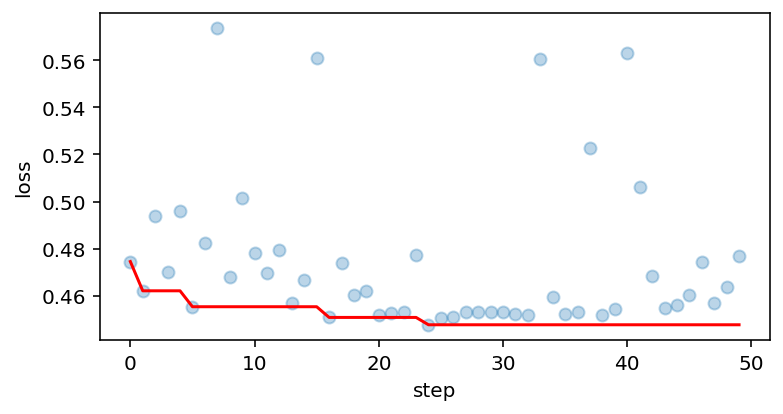

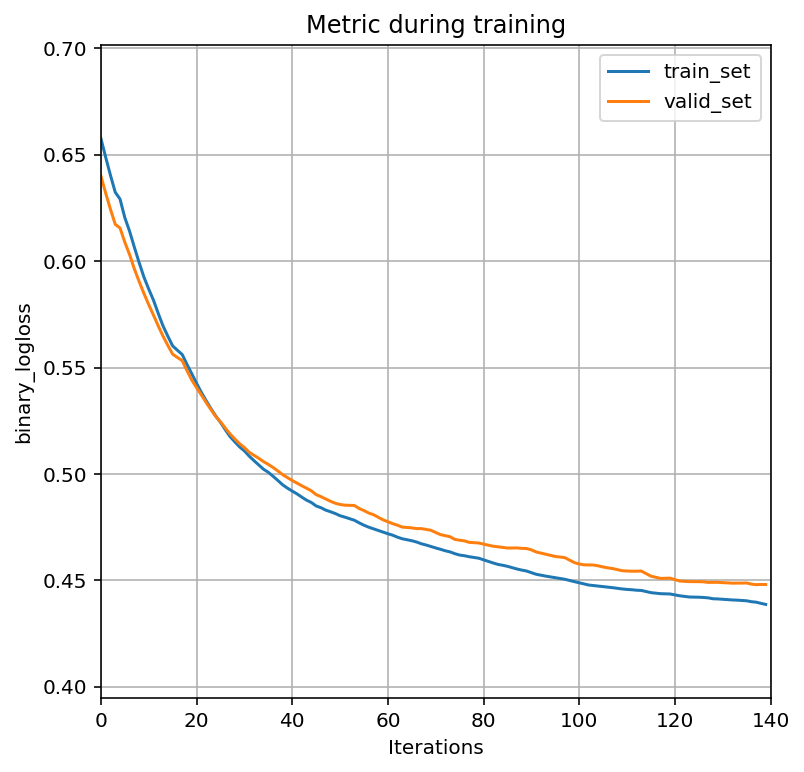

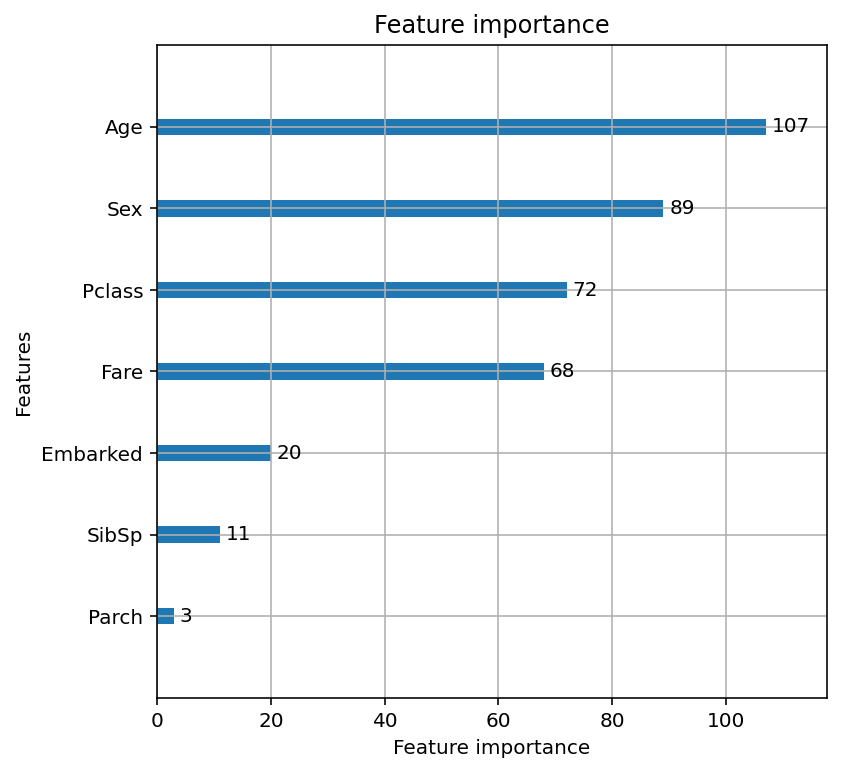

In [4]:
obj = auto_explain(train, 'Survived')
obj.tune_gbm(mode = 'binary')
# you will get a lightgbm model which is obj.gbm after this option

training shap explainer .....
shap explainer already trained, achieveing shap matrix. It will spend a lot of time(approx 30min per million data on bytedance notebook)
shap result already generated, you can use obj.save_explain to save result


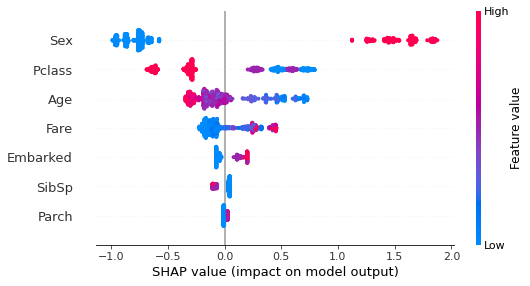

In [5]:
obj.train_shap()
# you will get obj.explainer and obj.shap_matrix after this option
# obj.explainer is trained shap object
shap_matrix = obj.shap_matrix

shap.summary_plot(shap_values=shap_matrix[1],
                 features=obj.x, # obj.x : all x data
                 feature_names=obj.x.columns.tolist())